## Модульное домашнее задание 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF
%matplotlib inline
pd.set_option('mode.chained_assignment', None)

## № 1
В первом задании требуется сделать базовый EDA (exploratory data analysis).  
Найдите зависимости в показателях, посмотрите на распределения этих показателей и сделайте соответствующие выводы.
Рекомендации подскажут вам с чего можно начать.  
• Постройте графики распределений показателей.  
• Посчитайте статистики, которые вы знаете.  
• Поищите зависимости между данными и подумайте о способах, которыми можно поискать эти зависимости.

### Решение
Посмотрим на данные с помощью pandas.

In [3]:
alco_df = pd.read_csv('data/var8_fixed.tsv', sep='\t')
print(alco_df.head())

   sex  age  curent_working  asi3_alc  asi4_dr  asi5_leg
0    0   18               1      0.12     0.30      0.06
1    1   30               1      6.00     0.27      0.00
2    0   23               0      0.30     0.30      0.07
3    0   20               1      0.05     0.26      0.00
4    0   20               0      0.78     0.23      0.00


Краткое описание стольбцов:  
age - возраст  
sex: 1 - женский пол, 0 - мужской  
curent_working: 1 - работает, 0 - не работает  
asi3_alc - употребление алкоголя   
asi4_dr - употребление наркотиков  
asi5_leg - проблемы с законом

Посмотрим на плотности распределения признаков:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a227b4050>,
      dtype=object)

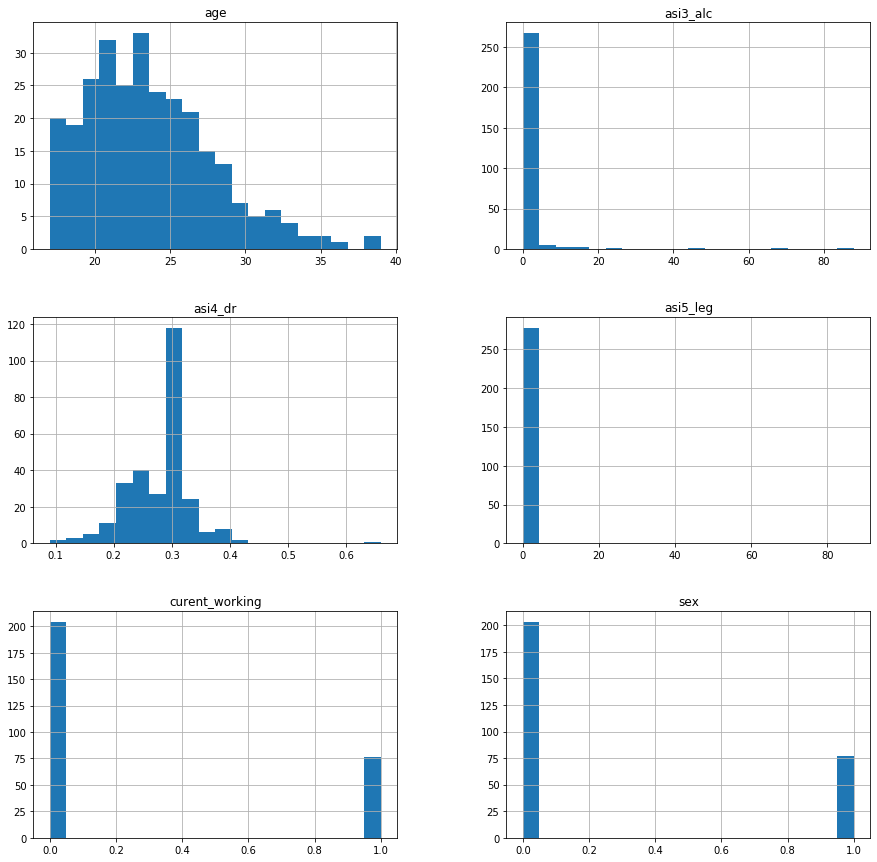

In [4]:
fig = plt.figure(figsize=(15, 15))
axes = fig.add_subplot(1, 1, 1)
alco_df.hist(column=['sex', 'age', 'curent_working', 'asi3_alc', 'asi4_dr', 'asi5_leg'], bins=20, ax=axes)

In [13]:
print(f'Стандартное отклонение для признака asi3_alc: {alco_df["asi3_alc"].std():.2f}')
asi3_95 = alco_df['asi3_alc'].quantile(0.95)
print(f'95 квантиль для признака asi3_alc: {asi3_95:.2f}')
print(f'Стандартное отклонение для признака asi5_leg: {alco_df["asi5_leg"].std():.2f}')
asi5_95 = alco_df['asi5_leg'].quantile(0.95)
print(f'95 квантиль для признака asi5_leg: {asi5_95:.2f}')

Стандартное отклонение для признака asi3_alc: 7.37
95 квантиль для признака asi3_alc: 0.78
Стандартное отклонение для признака asi5_leg: 5.21
95 квантиль для признака asi5_leg: 0.66


Видим подозрительно большую дисперсию в asi3_alc и asi5_leg, очистим от выбросов.  
Выберем в качестве верхней границы 95 квантиль.  
  
Посмотрим на статистики.

In [14]:
data = alco_df[(alco_df['asi3_alc'] < asi3_95) & (alco_df['asi5_leg'] < asi5_95)]
data.describe()

,sex,age,curent_working,asi3_alc,asi4_dr,asi5_leg
count,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000
mean,0.279528,23.614173,0.279528,0.080945,0.276654,0.124449
std,0.449653,4.261320,0.449653,0.098759,0.050054,0.158646
min,0.000000,17.000000,0.000000,0.000000,0.090000,0.000000
25%,0.000000,21.000000,0.000000,0.010000,0.250000,0.000000
50%,0.000000,23.000000,0.000000,0.050000,0.300000,0.060000
75%,1.000000,26.000000,1.000000,0.110000,0.300000,0.200000
max,1.000000,39.000000,1.000000,0.780000,0.410000,0.660000


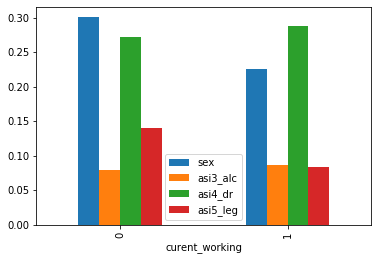

In [15]:
data.groupby('curent_working').agg({
    'sex': 'mean', 
    'asi3_alc': 'mean', 
    'asi4_dr': 'mean',
    'asi5_leg': 'mean'
}).plot(kind='bar')

Из этого графика видно, что у работающих людей значительно меншье проблем с законом.

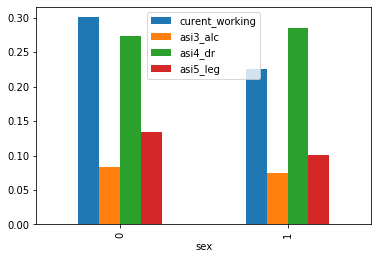

In [16]:
data.groupby('sex').agg({
    'curent_working': 'mean', 
    'asi3_alc': 'mean', 
    'asi4_dr': 'mean',
    'asi5_leg': 'mean'
}).plot(kind='bar')

Среди женщин больше доля безработных.

Построим корреляционный хитмап.

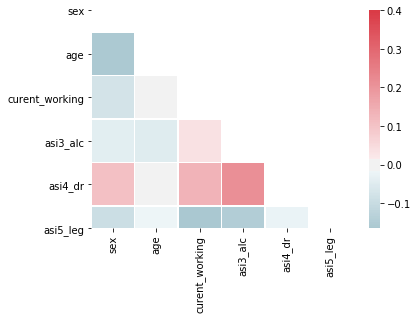

In [17]:
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4,  center=0,
            square=True, linewidths=.5)

Видим корреляцию показателей asi3_alc и asi4_dr, построим отдельный график.

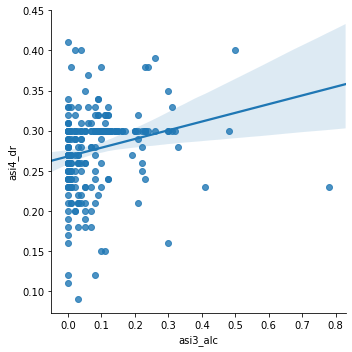

In [18]:
sns.lmplot(data=data, y='asi4_dr', x='asi3_alc')

Употребление алкоголя и наркотиков коррелируют.

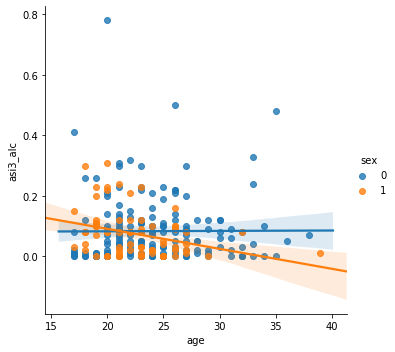

In [19]:
sns.lmplot(data=data, y='asi3_alc', x='age', hue='sex')

Чем старше женщина, тем меньше алкоголя она употребляет, для мужчин такого тренда нет.  
Взглянем на это по-другому, разбив данные на возрастные группы по с интервалом в 6 лет. 

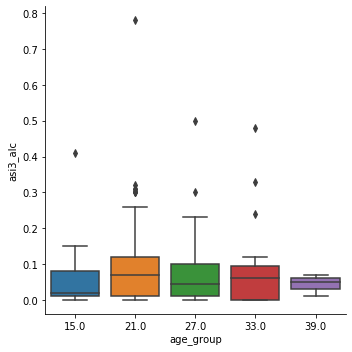

In [21]:
data['age_group'] = data.apply(lambda row: row.age // 6 * 6 + 3, axis=1)
sns.catplot(x="age_group", y="asi3_alc", kind="box", data=data)

Видим, что показатель, отвечающий за проблемы с алкоголем, снижается с возрастом.

## № 2
Пусть $x_{1}, \dots, x_{n} \sim \mathrm{N}\left(a, \sigma^{2}\right)$.

• Продемонстрируйте состоятельность выборочной дисперсии.  
• Продемонстрируйте, что выборочная дисперсия нормального распределения имеет
распределение хи-квадрат: $$n \frac{s_{n}^{2}}{\sigma^{2}} \sim \chi^{2}(n-1)$$

### Решение
#### Состоятельность
Выборочная дисперсия:
$S_n = \frac{1}{n}\sum_{i=1}^n (X_i - \overline{X}) = \overline{X^2} - (\overline{X})^2 $  
$ ES_n = E(\overline{X^2}) - E(\overline{X})^2 = E(\overline{X^2}) - (E \overline{X})^2 \to_{p} EX_1^2 - (EX_1)^2 = \sigma^2$, так состоятельны первый и второй моменты.  
Доказали состоятельность выборочной дисперсии:
$$ ES_n \to_{p} \sigma^2 \text{   при   } n \to \infty$$  
Теперь покажем это эспериментально для трех различных пар параметров $(a, \sigma)$

In [71]:
a1, b1 = 0, 1

a2, b2 = 0, 3

a3, b3 = 5, 5

eps = 0.1
n_experiments = 1000

Посчитам на сколько отличается выборочная дисперсия от настоящего значения при разных n.

In [72]:
diff1 = []
diff2 = []
diff3 = []


for n in range(1, 7):
    b1_miss_count = 0
    b2_miss_count = 0
    b3_miss_count = 0
    
    for experiment_idx in range(n_experiments):
        X1 = np.random.normal(a1, b1, 10 ** n)
        X2 = np.random.normal(a2, b2, 10 ** n)
        X3 = np.random.normal(a3, b3, 10 ** n)

        b1_n = X1.std()
        b2_n = X2.std()
        b3_n = X3.std()
        
        if abs(b1_n ** 2 - b1 ** 2) > eps:
            b1_miss_count += 1
        if abs(b2_n ** 2 - b2 ** 2) > eps:
            b2_miss_count += 1
        if abs(b3_n ** 2 - b3 ** 2) > eps:
            b3_miss_count += 1
            
    diff1.append(b1_miss_count / n_experiments)
    diff2.append(b2_miss_count / n_experiments)
    diff3.append(b3_miss_count / n_experiments)

Построим график вероятности отклонения выборочной дисперсии от реального значения.

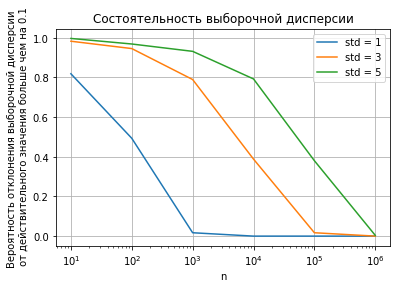

In [73]:
fig, ax = plt.subplots()
t = [10 ** i for i in range(1, 7)]
ax.plot(t, diff1, label='std = 1')
ax.plot(t, diff2, label='std = 3')
ax.plot(t, diff3, label='std = 5')


ax.set(xlabel='n', 
       ylabel=f'Вероятность отклонения выборочной дисперсии \n от действительного значения больше чем на {eps}',
       title='Состоятельность выборочной дисперсии')

ax.grid()
plt.xscale("log")
plt.legend()
plt.show()

Видим, что в не зависимости от конкретного значения параметра, вероятность отклонения выборочной дисперсии больше чем на $\varepsilon = 0.1$ стремится к 0.

#### Выборочная дисперсия имеет распределение хи-квадрат
Построим 3 выборки с различными средним, стандартным отклонением и числом элементов выборки.  
Построим соответствующее распределение Хи-квадрат.

In [36]:
a1 = 0
b1 = 1
n1 = 10 ** 4

a2 = 0
b2 = 1
n2 = 10 ** 2

a3 = 0
b3 = 4
n3 = 10 ** 3

In [37]:
Y1, Y2, Y3 = [], [], []
for i in range(100000):
    X1 = np.random.normal(a1, b1, n1)
    Y1.append(X1.std())
    
    X2 = np.random.normal(a2, b2, n2)
    Y2.append(X2.std())
    
    X3 = np.random.normal(a3, b3, n3)
    Y3.append(X3.std())
    
Y1 = np.array(Y1)
Y1 = Y1 ** 2 / (b1 ** 2) * n1

Y2 = np.array(Y2)
Y2 = Y2 ** 2 / (b2 ** 2) * n2

Y3 = np.array(Y3)
Y3 = Y3 ** 2 / (b3 ** 2) * n3

chi1 = np.random.chisquare(n1 - 1, 100000)
chi2 = np.random.chisquare(n2 - 1, 100000)
chi3 = np.random.chisquare(n3 - 1, 100000)

Построим парные графики для функции распределения дисперсии (а точнее величины $n \frac{s_{n}^{2}}{\sigma^{2}}$) и хи-квадрат $\chi^{2}(n-1)$ и сравним.

In [38]:
Y1.sort()
ecdf_Y1 = ECDF(Y1, side='left')
chi1.sort()
ecdf_ch1 = ECDF(chi1, side='left')

Y2.sort()
ecdf_Y2 = ECDF(Y2, side='left')
chi2.sort()
ecdf_ch2 = ECDF(chi2, side='left')

Y3.sort()
ecdf_Y3 = ECDF(Y3, side='left')
chi3.sort()
ecdf_ch3 = ECDF(chi3, side='left')

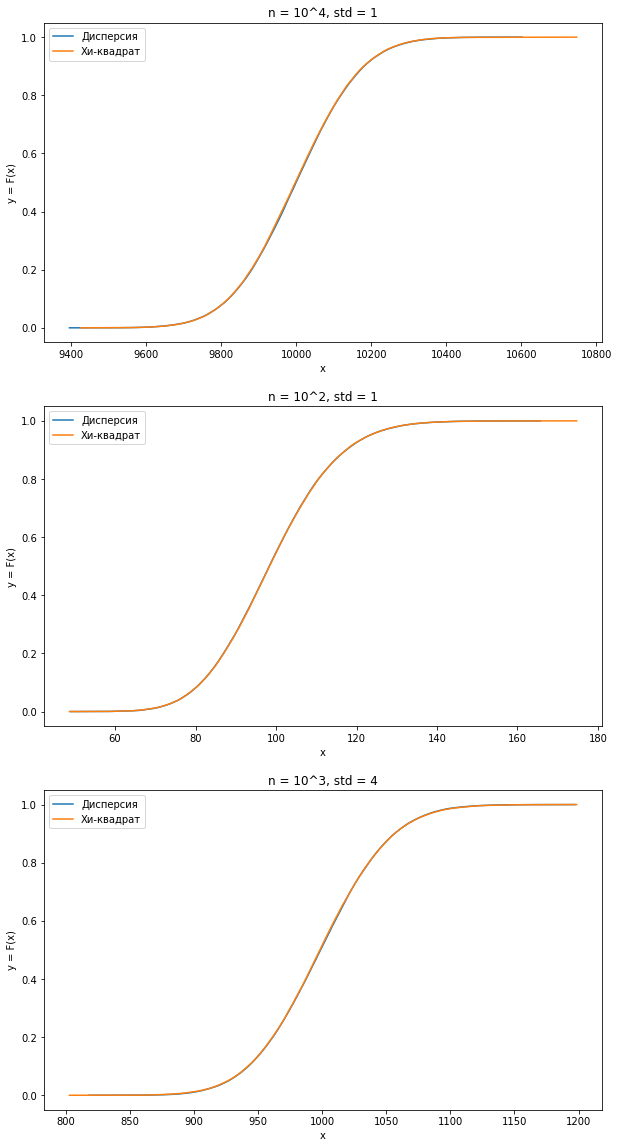

In [46]:
fig, axs = plt.subplots(nrows=3, figsize=(10,20))

axs[0].title.set_text('n = 10^4, std = 1')
axs[0].set(xlabel='x', ylabel='y = F(x)')
sns.lineplot(x=ecdf_Y1.x, y=ecdf_Y1.y, label='Дисперсия', ax=axs[0])
sns.lineplot(x=ecdf_ch1.x, y=ecdf_ch1.y, label='Хи-квадрат', ax=axs[0])

axs[1].title.set_text('n = 10^2, std = 1')
axs[1].set(xlabel='x', ylabel='y = F(x)')
sns.lineplot(x=ecdf_Y2.x, y=ecdf_Y2.y, label='Дисперсия', ax=axs[1])
sns.lineplot(x=ecdf_ch2.x, y=ecdf_ch2.y, label='Хи-квадрат', ax=axs[1])

axs[2].title.set_text('n = 10^3, std = 4')
axs[2].set(xlabel='x', ylabel='y = F(x)')
sns.lineplot(x=ecdf_Y3.x, y=ecdf_Y3.y, label='Дисперсия', ax=axs[2])
sns.lineplot(x=ecdf_ch3.x, y=ecdf_ch3.y, label='Хи-квадрат', ax=axs[2])

Как видно из графиков, вне зависимости от параметров распределения и для различного числа элементов выборки, функции распределения (а значит и сами распределеня) совпадают.

## № 3
Случайная величина x распределена равномерно на отрезке (0, θ). Верно, что интервал

$$\left(\max _{i} x_{i}, \frac{\max _{i} x_{i}}{(1-\gamma)^{1 / n}}\right)$$


является доверительным для уровня γ в такой модели. Постройте этот доверительный интервал, продемонстрируйте, что он действительно доверительный с указанной вероятностью.

### Решение
Построим функцию, которая будет вычилсять доверительный интервал для равномерного распределения.

In [234]:
def confint(X, gamma=0.95):
    """Calculate confidence interval for dataset X with confidence level gamma"""
    
    n_items = len(X)
    left = max(X)
    right = left / (1 - gamma) ** (1 / n_items)
    return left, right

Функция check_uniform_confint принимает правую границу равномерного распределения - theta,
требуемый уровень доверия - gamma и n_times проверяет, попает ли реальное значения параметра theta в построенный доверительный интервал с необходимой частотой.

In [235]:
def check_uniform_confint(theta, gamma, n_elements=10000, n_times=1000):
    """Check that true parameter value is in confidence interval with frequency gamma"""
    
    miss_count = 0

    for _ in range(n_times):
        X = np.random.uniform(0, theta, n_elements)
        left, right = confint(X, gamma)
        if not (left <= theta <= right):
            miss_count +=1
    
    p = 1 - miss_count / n_times
    return p, p > gamma

Проведем испытание для трех различных пар $(\theta, \gamma)$:

In [236]:
theta_values = 10, 10, 531
gamma_values = 0.95, 0.99, 0.997
n_times = 30000

for theta, gamma in (zip(theta_values, gamma_values)):
    p, success = check_uniform_confint(theta, gamma, n_times=n_times)
    print(f'Для равномерного распределения на [0, {theta}] действительное значение параметра ' 
          f'попадает в доверительный интервал с уровнем доверия {gamma} '
          f'с частотой {p} при {n_times} испытаний. \n'
          f'{"Успех!" if success else "Неудача("}')

Для равномерного распределения на [0, 10] действительное значение параметра попадает в доверительный интервал с уровнем доверия 0.95 с частотой 0.9508666666666666 при 30000 испытаний. 
Успех!
Для равномерного распределения на [0, 10] действительное значение параметра попадает в доверительный интервал с уровнем доверия 0.99 с частотой 0.9903 при 30000 испытаний. 
Успех!
Для равномерного распределения на [0, 531] действительное значение параметра попадает в доверительный интервал с уровнем доверия 0.997 с частотой 0.9975 при 30000 испытаний. 
Успех!


Как видно из эксперимента, частота попадания значения параметра в доверительный интервал с уровенем $\gamma$ действительно равна $\gamma$ с учетом погрешности вычислений.

## № 4
Пусть $x_1, \dots , x_n$ — независимые одинаково распределенные случайные величины с функцией распределения $F(x)$.  
Обозначим $F_n(x)$ эмпирическую функцию распределения для $x_1, \dots , x_n$:

$$ F_n(x) = \frac{\#\{i : x_i < x\}}{n} $$
Продемонстрируйте выполнение теоремы Гливенко-Кантелли:

$$ \sup_{x \in R} |F(x) - F_n(x)| \overset{n \rightarrow \infty}{\longrightarrow} 0$$.

Указание: в силу «ступенчатости» функции $F_n(x)$ супремум достигается на конечном
множестве точек.

### Решение
Построим функцию, которая по выборке будет возвращать эмпирическую функцию распределения.

In [25]:
def build_empirical_dist_function(X):
    n_items = len(X)
    variation_series = sorted(X)
    first_item = variation_series[0]
    last_item = variation_series[-1]
    
    def empirical_dist_function(y):
        if y < first_item:
            return 0
        
        if y >= last_item:
            return 1
        
        for i, x in enumerate(variation_series):
            if y <= x:
                return i / n_items
        return 1
    return empirical_dist_function

### $NB$
Заметим, что функция распределения монотонно неубывающая, а значит супремум может быть достигнут только на элементах выборки.

[Text(0, 0.5, 'y = F(x)'), Text(0.5, 0, 'x')]

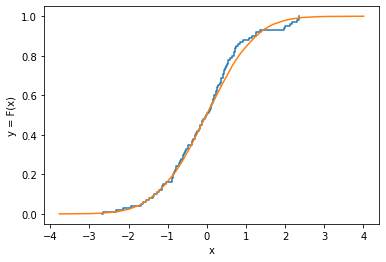

In [45]:
# empirical distribution
X = np.random.normal(0, 1, 100)
x = sorted(X)
emp_dist_func = build_empirical_dist_function(X)
y = list(map(emp_dist_func, x))
plt.step(x, y, where='post')

# "real" distribution
X = np.random.normal(0, 1, 10000)
x_true = sorted(X)
emp_dist_func = build_empirical_dist_function(X)
y_true = list(map(emp_dist_func, x_true))
ax = sns.lineplot(x=x_true, y=y_true)
ax.set(xlabel='x', ylabel='y = F(x)')


Проверим для трех распределений:  
1) Логистического $L(\mu, s)$ с параметрами $ \mu = 2, s = 1 $  
2) Коши $C(x_0, \gamma)$ с параметрами $ x_0 = 0, \gamma = 1 $  
3) Дискретное:  

| x ||  1  |  2  |  3  |  7  |
|---||-----|-----|-----|-----|
| p || 0.1 | 0.1 | 0.2 | 0.5 |

Функции распределения:

In [165]:
def logistic_dist_function(y):
    """Logistic distribution function with mu = 2 and s = 1"""
    return 1 / (1 + np.exp(2 - y)) 


def cauchy_dist_function(y):
    """Cauchy distribution function with x = 2 and gamma = 1"""
    return np.arctan(y) / np.pi  + 0.5


def discrete_dist_function(y):
    """Discrete distribution function"""
    if y <= 1:
        return 0
    if y <= 2:
        return 0.1
    if y <= 3:
        return 0.3
    if y <= 7:
        return 0.5
    return 1


def array_discrete_dist_function(y):
    """
    Discrete distribution function that applies 
    empirical dist function to every point of X
    """
    c = Counter(X)
    Y = [0] * c[1] + [0.1] * c[2] + [0.3] * c[3] + [0.5] * c[7]
    return np.array(Y)

Вспомогательные функции для подсчета супремума и построения графиков.

In [166]:
def calc_supremum(X, dist_function):
    X.sort()
    ecdf = ECDF(X, side='left')
    max_diff = np.max(np.abs(dist_function(X) - ecdf(X)))
    return max_diff


def plot_supremum(sample_sizes, supremum_list, dist_name):
    
    plt.figure(figsize=(10, 8))
    plt.title(f'Проверка теоремы Гливенко-Кантелли для {dist_name}.')
    plt.xlabel('Размер выборки n')
    plt.ylabel('Супремум разницы функции распределения \n и эмприрической функции распределения')
    plt.xscale("log")
    plt.plot(sample_sizes, supremum_list)

### Для логистического распределения

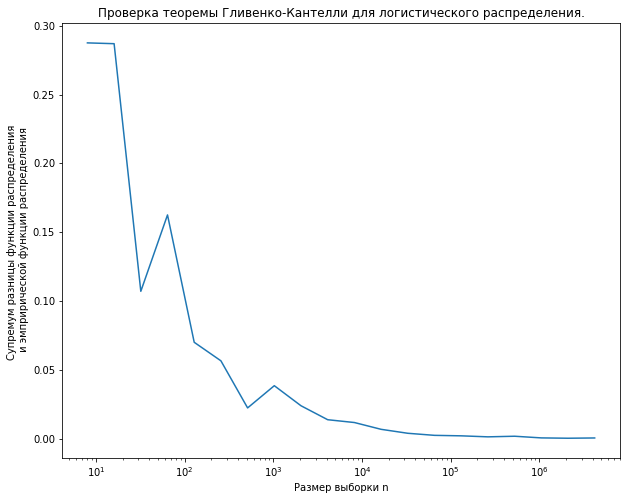

In [167]:
sup = []
sample_sizes = [2 ** i for i in range(3, 23)]

for n_elements in sample_sizes:
    X = np.random.logistic(2, 1, n_elements)
    sup.append(calc_supremum(X, logistic_dist_function))


plot_supremum(sample_sizes, sup, 'логистического распределения')

### Для распределения Коши

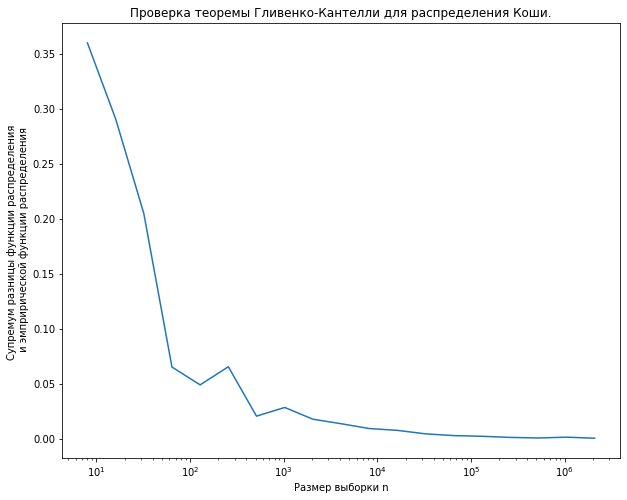

In [168]:
sup = []
sample_sizes = [2 ** i for i in range(3, 22)]

for n_elements in sample_sizes:
    X = np.random.standard_cauchy(n_elements)
    sup.append(calc_supremum(X, cauchy_dist_function))

plot_supremum(sample_sizes, sup, 'распределения Коши')

### Для дискретного распределения

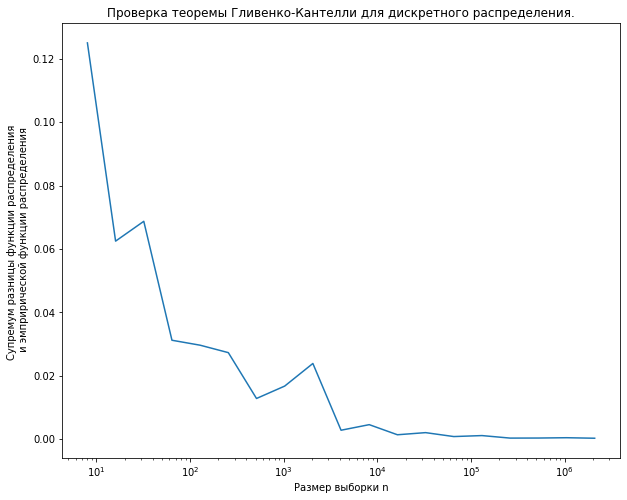

In [169]:
sup = []
sample_sizes = [2 ** i for i in range(3, 22)]

for n_elements in sample_sizes:
    X = np.random.choice((1, 2, 3, 7), n_elements, p=(0.1, 0.2, 0.2, 0.5))
    sup.append(calc_supremum(X, array_discrete_dist_function))

plot_supremum(sample_sizes, sup, 'дискретного распределения')

Как видно из графиков супремум разности генеральной и эмпирической функций распределения стремится к 0 при возрастании n.